In [28]:
import os
import sys
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image


import Dataset
import utils
from engine import train_one_epoch, evaluate, get_model_result


%matplotlib inline

In [4]:
classes = ("people")

num_classes = len(classes)+1  # n class + background

batch_size = 3

num_epochs = 5

root = u"../datasets/PennFudanPed"

In [5]:
dataset_train = Dataset.DatasetGen(root, Dataset.get_transform(horizontal_flip=True), train=True)
dataset_test = Dataset.DatasetGen(root, Dataset.get_transform(horizontal_flip=False), train=False)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0,
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device

device(type='cuda')

In [7]:
anchor_generator = torchvision.models.detection.rpn. \
    AnchorGenerator(sizes=((32,), (24, ), (24, ), (16,), (8, )),
                                        aspect_ratios=([1.0, 1.0, 1.0, 1.0], 
                                                     [0.8, 1.0, 1.0, 1.0], 
                                                     [1.0, 0.8, 1.0, 1.0],
                                                     [1.0, 1.0, 1.0, 1.0],
                                                     [1.0, 1.0, 1.0, 1.0]))

In [8]:
model.rpn.anchor_generator = anchor_generator
model.rpn.head = torchvision.models.detection.faster_rcnn. \
    RPNHead(256, anchor_generator.num_anchors_per_location()[0])
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn. \
    FastRCNNPredictor(in_features, num_classes)


In [9]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [10]:
if False:#make this 1 for training to happen
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1)
        lr_scheduler.step()
        evaluate(model, data_loader_test, device=device)

    print("Training complete!")
    
    torch.cuda.synchronize()
    # create directory for saving the model
    print("Saving model...")
    torch.save(model, "model.pth")
    print("Model saving complete!")


Epoch: [0]  [ 0/24]  eta: 0:00:12  lr: 0.000222  loss: 7.9058 (7.9058)  loss_classifier: 1.5750 (1.5750)  loss_box_reg: 0.0015 (0.0015)  loss_objectness: 0.6944 (0.6944)  loss_rpn_box_reg: 5.6349 (5.6349)  time: 0.5039  data: 0.0393  max mem: 2916
Epoch: [0]  [ 1/24]  eta: 0:00:09  lr: 0.000439  loss: 6.6692 (7.2875)  loss_classifier: 1.5750 (1.5967)  loss_box_reg: 0.0015 (0.0023)  loss_objectness: 0.6944 (0.6945)  loss_rpn_box_reg: 4.3531 (4.9940)  time: 0.3959  data: 0.0425  max mem: 2925
Epoch: [0]  [ 2/24]  eta: 0:00:08  lr: 0.000657  loss: 6.6692 (6.9448)  loss_classifier: 1.5750 (1.5292)  loss_box_reg: 0.0030 (0.0027)  loss_objectness: 0.6947 (0.6958)  loss_rpn_box_reg: 4.3531 (4.7170)  time: 0.3922  data: 0.0477  max mem: 3990
Epoch: [0]  [ 3/24]  eta: 0:00:07  lr: 0.000874  loss: 6.6692 (6.9344)  loss_classifier: 1.3942 (1.3713)  loss_box_reg: 0.0015 (0.0024)  loss_objectness: 0.6947 (0.6960)  loss_rpn_box_reg: 4.3531 (4.8646)  time: 0.3739  data: 0.0434  max mem: 3990
Epoch: [

[{'boxes': tensor([[252.9804,  22.2588, 364.2001, 307.5718],
        [121.1182,  48.1021, 230.7170, 321.1729]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9741, 0.9676], device='cuda:0', grad_fn=<IndexBackward>)}]


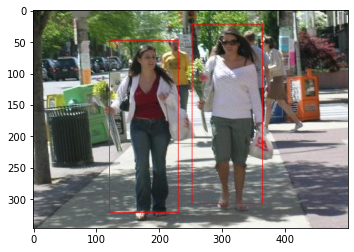

In [40]:
model = torch.load("model.pth")

model.to(device)
x = os.path.join(root,"PNGImages")
x = os.listdir(x)
while True:
    _ = x[np.random.randint(len(x))]
    if _[0] != '.':
        x = _
        break
img = Image.open(os.path.join(root,"PNGImages",x))
x = img
img = np.array(img)
x = torchvision.transforms.ToTensor()(x)
x = torch.as_tensor(np.array([x.numpy()]))
x = x.to(device)
y = model(x)
print(y)
for data in y:
    for box in data["boxes"].to('cpu').detach().numpy():
        box = box.astype(np.int16)
        img = cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),(255,0,0))
    plt.imshow(img)